# Pre-Processing Workflow
As a rule, if any pre-processing is to be done on the samples I prefer to do it prior to training and to store the pre-processed data separately. For a fully trained model it is better to run the transformers in the normal manner, but during training it adds unnecessarily to runtime, as the pre-processing is applied every epoch.

Still, this creates some inflexibility, as tuning the pre-processing steps becomes far more tedious.

My solution is to run hyper-parameter tuning on a small batch of the data using a toy model, evaluate that model's success via cross-validation, and then use those values to pre-process the entire dataset.

Obviously even the above would be useless without a general sense of what techniques should be applied to what kinds of data.

In [2]:
%load_ext autoreload
%autoreload 2

import sys; sys.path.append('./*'); sys.path.append('..')

import torch
import torch.nn as nn
from torchvision.transforms import v2
from torch.utils.data import DataLoader, Dataset, random_split
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from os import path
from trainer import Trainer
import pandas as pd
import numpy as np

torch.manual_seed(0)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
d = '../sheet_data'

In [8]:
from datasets.ClassificationSet import ClassificationSet
from models.SheetClassifier import SheetClassifier

# Load the dataset
full_data = pd.read_csv(f'{path.join(d, "training_set")}/metadata.csv')
dummy_parameters = SheetClassifier().state_dict()
trainer = Trainer()

# from sklearn.model_selection import StratifiedShuffleSplit would have given us the same distrobution as the original
train_set, test_set, y_train, y_test = train_test_split(full_data, full_data.target, train_size=.1, test_size=0.1, random_state=0, stratify=full_data.target)
train_set['target'] = y_train; test_set['target'] = y_test

# Show levels of targets are equivalent
print('Bubbles to Line in Training',round(len(y_train[y_train == 1])/len(y_train[y_train == 2]),2))
print('Bubbles to Line in Testing',round(len(y_test[y_test == 1])/len(y_test[y_test == 2]),2))

Bubbles to Line in Training 1.01
Bubbles to Line in Testing 1.0


In [ ]:
import optuna

#====
epochs = 20
show = False
#====
results = pd.DataFrame([], columns=['blur_value', 'norm_mean', 'norm_std', 'accuracy', 'loss'])

def objective(trial, gaussian_blur:int=None, norm_mean:float=None, norm_std:float=None, record:bool=True, show:bool=False):
    gaussian_blur = trial.suggest_int('gaussian_blur', 1, 5, step=2) if not gaussian_blur else gaussian_blur
    norm_mean = trial.suggest_float('norm_mean', -.9, .9) if not norm_mean else norm_mean
    norm_std = trial.suggest_float('norm_std', .01, .9) if not norm_std else norm_std

    transform = v2.Compose([
                v2.ToImage(),
                v2.ToDtype(torch.float32, scale=True),
                v2.GaussianBlur(gaussian_blur),
                v2.Normalize([norm_mean], [norm_std], inplace=True),
                ]
            )
    c_train = ClassificationSet(path.join(d, 'training_set'), train_set, transform)
    c_test = ClassificationSet(path.join(d, 'training_set'), test_set, transform)

    temp_model = SheetClassifier()
    temp_model.load_state_dict(dummy_parameters)

    trainer.run_experiment(temp_model, c_train, c_test, criterion=nn.CrossEntropyLoss, epochs=epochs, show=show, train_shuffle=False, test_shuffle=False)
    trainer.evaluate_model(temp_model, show=show)

    if record: results.loc[len(results)] = [gaussian_blur, norm_mean, norm_std, trainer.model_accuracy, trainer.model_loss]
    return trainer.model_accuracy

In [10]:
study = optuna.create_study(direction='maximize', sampler=optuna.samplers.RandomSampler(seed=0))
study.optimize(objective, n_trials=20)

[I 2025-03-12 13:43:13,598] A new study created in memory with name: no-name-316d11a8-a2db-47a6-9a89-dd7102be46e1
[I 2025-03-12 13:43:26,849] Trial 0 finished with value: 0.6880000233650208 and parameters: {'gaussian_blur': 3, 'norm_mean': 0.21518936637241948, 'norm_std': 0.36563039188226987}. Best is trial 0 with value: 0.6880000233650208.
[I 2025-03-12 13:43:34,690] Trial 1 finished with value: 0.6679999232292175 and parameters: {'gaussian_blur': 3, 'norm_mean': -0.07634520066109529, 'norm_std': 0.3910775267093271}. Best is trial 0 with value: 0.6880000233650208.
[I 2025-03-12 13:43:42,533] Trial 2 finished with value: 0.6880000233650208 and parameters: {'gaussian_blur': 3, 'norm_mean': 0.39177300078207977, 'norm_std': 0.5785610286956072}. Best is trial 0 with value: 0.6880000233650208.
[I 2025-03-12 13:43:50,506] Trial 3 finished with value: 0.6880000233650208 and parameters: {'gaussian_blur': 3, 'norm_mean': 0.2917250380826646, 'norm_std': 0.3220480026542136}. Best is trial 0 with 

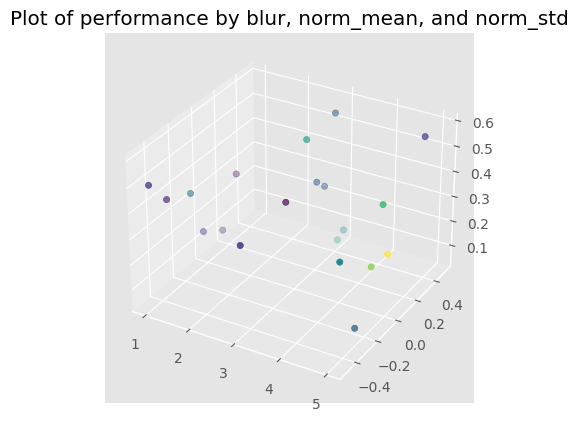

In [11]:
# importing mplot3d toolkits, numpy and matplotlib
import matplotlib.pyplot as plt
 
fig = plt.figure()
 
# syntax for 3-D projection
ax = plt.axes(projection ='3d')
 
# defining all 3 axis
 
# plotting
ax.scatter(results.blur_value, results.norm_mean, results.norm_std, c=results.accuracy)
ax.set_title('Plot of performance by blur, norm_mean, and norm_std')
plt.show()

C:\Users\slayt\AppData\Local\Temp\ipykernel_6036\3552502145.py:1: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_optimization_history(study)
C:\Users\slayt\AppData\Local\Temp\ipykernel_6036\3552502145.py:2: ExperimentalWarning: plot_parallel_coordinate is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_parallel_coordinate(study)
C:\Users\slayt\AppData\Local\Temp\ipykernel_6036\3552502145.py:3: ExperimentalWarning: plot_slice is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_slice(study, params=['gaussian_blur', 'norm_mean', 'norm_std'])
C:\Users\slayt\AppData\Local\Temp\ipykernel_6036\3552502145.py:4: ExperimentalWarning: plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  optun

<Axes: title={'left': 'Hyperparameter Importances'}, xlabel='Hyperparameter Importance', ylabel='Hyperparameter'>

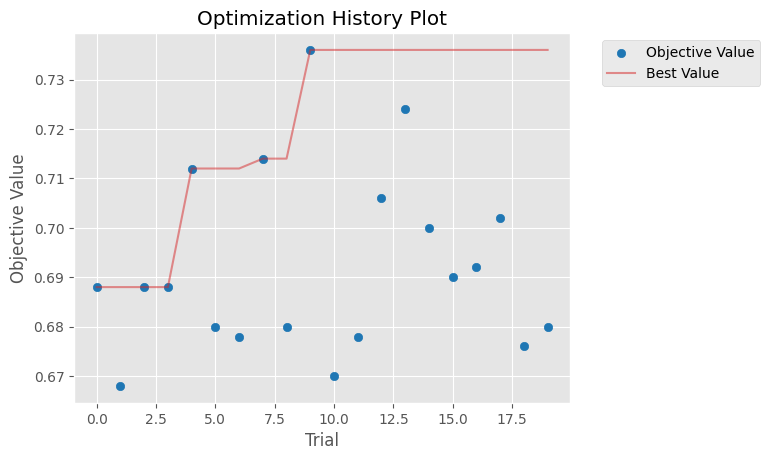

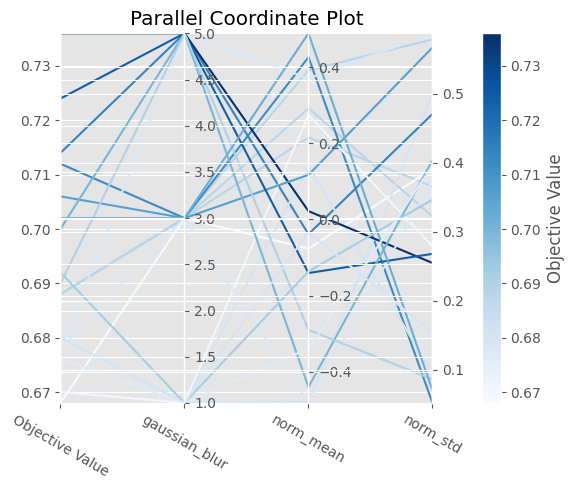

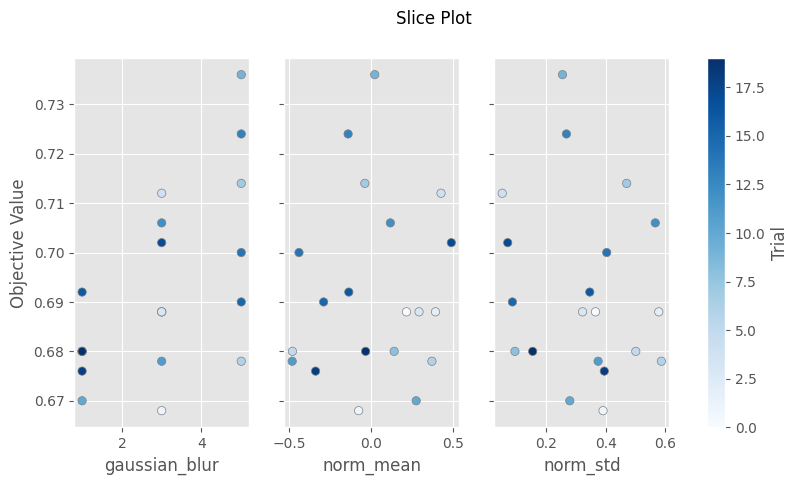

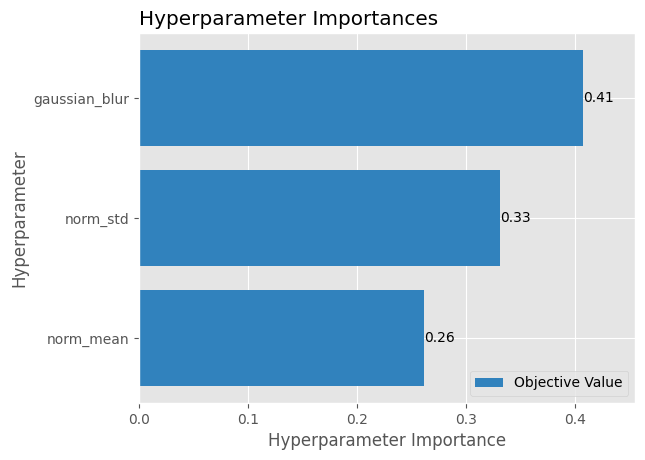

In [12]:
optuna.visualization.matplotlib.plot_optimization_history(study)
optuna.visualization.matplotlib.plot_parallel_coordinate(study)
optuna.visualization.matplotlib.plot_slice(study, params=['gaussian_blur', 'norm_mean', 'norm_std'])
optuna.visualization.matplotlib.plot_param_importances(study)

In [13]:
# Choose best and worst parameters and prep full run
best = results.sort_values('accuracy')[::-1][:3]
worst = results.sort_values('accuracy')[:3]
print('Best Performers',best,'\n\nWorst Performers',worst)

eval_train_set, eval_test_set, y_train, y_test = train_test_split(full_data, full_data.target, train_size=.8, random_state=0, stratify=full_data.target)
eval_train_set['target'] = y_train; eval_test_set['target'] = y_test

Best Performers     blur_value  norm_mean  norm_std        accuracy      loss
9            5   0.021848  0.254651  tensor(0.7360)  4.853170
13           5  -0.140492  0.267849  tensor(0.7240)  5.472957
7            5  -0.038521  0.470512  tensor(0.7140)  5.100746 

Worst Performers     blur_value  norm_mean  norm_std        accuracy      loss
1            3  -0.076345  0.391078  tensor(0.6680)  5.423141
10           1   0.274234  0.279129  tensor(0.6700)  2.989881
18           1  -0.338690  0.395334  tensor(0.6760)  3.072015


In [14]:
# Training a full run on the best
entry = best.iloc[0]
print(entry)
objective(None, entry.blur_value, entry.norm_mean, entry.norm_std, record=False, show=True)

blur_value                 5
norm_mean           0.021848
norm_std            0.254651
accuracy      tensor(0.7360)
loss                 4.85317
Name: 9, dtype: object
Epoch [1/20], Train Loss: 9.57, Accuracy: 0.53
Epoch [6/20], Train Loss: 1.07, Accuracy: 0.85
Epoch [11/20], Train Loss: 0.26, Accuracy: 0.97
Epoch [16/20], Train Loss: 0.20, Accuracy: 0.96
Experiment Complete
[Evaluation over 5 Batches], Test Loss: 5.29, Accuracy: 0.71


tensor(0.7080)

In [ ]:
# Training a full run on the best
entry = worst.iloc[0]
print(entry)
objective(None, entry.blur_value, entry.norm_mean, entry.norm_std, record=False, show=True)

Epoch [1/20], Train Loss: 12.10, Accuracy: 0.52
Epoch [6/20], Train Loss: 0.42, Accuracy: 0.95
Epoch [11/20], Train Loss: 0.05, Accuracy: 0.99
Epoch [12/20], Train Loss: 0.09, Accuracy: 0.99
Epoch [13/20], Train Loss: 0.03, Accuracy: 0.99
Epoch [14/20], Train Loss: 0.02, Accuracy: 1.00
Epoch [15/20], Train Loss: 0.02, Accuracy: 1.00
Epoch [16/20], Train Loss: 0.02, Accuracy: 1.00
Epoch [17/20], Train Loss: 0.00, Accuracy: 1.00
Epoch [18/20], Train Loss: 0.01, Accuracy: 1.00
Epoch [19/20], Train Loss: 0.00, Accuracy: 1.00
Epoch [20/20], Train Loss: 0.02, Accuracy: 1.00
Experiment Complete
[Evaluation over 5 Batches], Test Loss: 5.07, Accuracy: 0.68


tensor(0.6820)

### Our Best Pre-Processed Samples Outperformed our Worst by 10% Accuracy
Note, it looks like the lowest values tended to have the least blur, and further, that those parameters did well in the training but poorely in testing, this is a classic example of overfitting, and another reason why this much care in the pre-processing phase *matters*.

## Apply the Best Transformer to the Data as a Pre-processing Step

In [21]:
transfer_dir = '../sheet_data/preprocessed_training_set'
entry = best.iloc[0]
transform = v2.Compose([
                v2.ToImage(),
                v2.ToDtype(torch.float32, scale=True),
                v2.GaussianBlur(entry.blur_value),
                v2.Normalize([entry.norm_mean], [entry.norm_std], inplace=True)
                ])
preprocess_set = ClassificationSet(path.join(d, 'training_set'), transform=transform)
preprocess_set.transform_pass(transfer_dir, delete_prior_contents=True)

## Test the Speed of Training Between Preprocessed and On Call Processed
Now that we see the accuracy benefit of finding the best pre-processed settings, let's finally look at the speed benefit of applying the pre-processing to saved samples over oncall loading.

In [ ]:
dpre_processed = '../sheet_data/preprocessed_training_set'
model = SheetClassifier()
model.load_state_dict(dummy_parameters)

transform = v2.Compose([
                v2.ToImage(),
                v2.ToDtype(torch.float32, scale=True),
                v2.GaussianBlur(entry.blur_value),
                v2.Normalize([entry.norm_mean], [entry.norm_std])
                ])
normal_set = ClassificationSet(path.join(d, 'training_set'), transform=transform)
preprocessed_dataset = ClassificationSet(dpre_processed)

In [119]:
trainer.evaluate_model(model, DataLoader(normal_set, 10))

[Evaluation over 500 Batches], Test Loss: 3.20, Accuracy: 0.30


SheetClassifier(
  (model): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (lin1): Linear(in_features=16384, out_features=3, bias=True)
)

In [121]:
trainer.evaluate_model(model, DataLoader(preprocessed_dataset, 10))

[Evaluation over 500 Batches], Test Loss: 2.94, Accuracy: 0.30


SheetClassifier(
  (model): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (lin1): Linear(in_features=16384, out_features=3, bias=True)
)

## Results
As we can see, using the pre-processed dataset takes 20% of the time of the non-preprocessed set (2s vs 10s), as shown above.